<h1> Getting the data for the single cell RNA analysis </h1>

One major goal of our project is indentify  transcription factors that contribute to cell-type identity of germ cells. It will be done by clustering gene-expression profiles for each cell type using only the <b>1505 transcription factors </b> expressed in a recently published dataset.
<br>

The purpose of this part of the analysis is to import, integrate and normalise scRNA-seq datasets using R/Bioconductor packages.  In this workflow, we go from preprocessing the data to integrating the data and normalising. The normalisation will be done by computing the size factors using the scran package’s computeSumFactors() function, and apply the size factors via logcounts, within a SingleCellExperiment object.
<br><br>
Here, we will be using raw data from EMBL-EBI (https://www.ebi.ac.uk/arrayexpress/experiments/E-MTAB-6946/)(Ernst et al. 2019). The datasets have the expression data from testicular germ cells from rom juvenile animals at post-natal day P5-P35 as well as adult animals. Gene information was collected from org.Mm.eg.db, GO.db using Bioconductor packages.
<br><br>
Our goal is to get the data and get it fit to use in one single object to facilitate downstream analysis, such as clustering.

<br>


<h2>Data exploration, transformation and enrichment</h2>

In [56]:
library(Matrix)
library("data.table")
library(edgeR)
library(SingleCellExperiment)
library(scran)
library(scuttle)
library(scater)


Attaching package: ‘scater’


The following object is masked from ‘package:limma’:

    plotMDS




<h4> Load Ernst data </h4>

The raw_counts.mtx is a big file of 3.1 Gb.

In [30]:
# Load Ernst data 
raw_counts <- readMM('data/ernst/raw_counts.mtx') #load the data as a sparse matrix

In [31]:
# Check counst table
raw_counts[1:5,1:5] #This takes time as the raw_counts.mtx file is 3.01 GB 
dim(raw_counts)

5 x 5 sparse Matrix of class "dgTMatrix"
              
[1,] . . . . .
[2,] . . . . .
[3,] . . . . .
[4,] . . . . .
[5,] . . . . .

[1] 33226 53510

<b>raw_counts</b> matrix has 33226 genes and 53510 cells in a sparse matrix (genes are rows and cells are colummns).

In [4]:
# Load metadata and genes
cell_metadata <- read.delim("data/ernst/cell_metadata.txt", header = TRUE, sep = " ", dec = ".")


names(cell_metadata) #Check metadata of the table
head(cell_metadata)


[1] "Sample"                         "Barcode"                       
 [3] "Library"                        "is_cell_control"               
 [5] "total_features_by_counts"       "log10_total_features_by_counts"
 [7] "total_counts"                   "log10_total_counts"            
 [9] "pct_counts_in_top_50_features"  "pct_counts_in_top_100_features"
[11] "pct_counts_in_top_200_features" "pct_counts_in_top_500_features"
[13] "BroadClusters"                  "AnnotatedClusters"

,Sample,Barcode,Library,is_cell_control,total_features_by_counts,log10_total_features_by_counts,total_counts,log10_total_counts,pct_counts_in_top_50_features,pct_counts_in_top_100_features,pct_counts_in_top_200_features,pct_counts_in_top_500_features,BroadClusters,AnnotatedClusters
,<chr>,<chr>,<chr>,<lgl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,B6,AAACCTGAGATGGCGT-1,do17815,FALSE,4761,3.677789,41018,4.612985,26.05929,34.15817,45.16798,63.93778,Germ,S9
2,B6,AAACCTGAGTTCGATC-1,do17815,FALSE,3211,3.506776,20236,4.306146,30.46057,39.52856,51.37379,70.47341,Germ,S10
3,B6,AAACCTGTCAAGATCC-1,do17815,FALSE,6175,3.790707,41335,4.616328,12.71078,19.64437,29.30204,46.93117,Germ,S3
4,B6,AAACCTGTCACGATGT-1,do17815,FALSE,4873,3.687886,13920,4.143670,13.06753,20.39511,29.67672,45.41667,Germ,Spermatogonia
5,B6,AAACCTGTCTGCTGCT-1,do17815,FALSE,6029,3.780317,48207,4.683119,14.77379,21.76862,31.58670,50.32672,Germ,S6
6,B6,AAACGGGCAGCCAATT-1,do17815,FALSE,5796,3.763203,42084,4.624127,13.13088,20.28324,30.40110,49.39169,Germ,S6


The data frame of the metadata (cell_metadata) of the cells gives us three valuable pieces of information. Sample is the age of the mice (B6 is adult, and P is days after birth). BroadCluster is the broad type of cell (germ or somatic cell). AnnotatedCluster is the type of cell. the name is based on the expression of different gene markers (genes expressed in specific typer of cells)

In [5]:
table(cell_metadata$Sample) # Different ages of the mice B6 is adult, and P means days after birth. 


   B6   P10   P15   P20   P25   P30   P35    P5   Tc0   Tc1 
 3355  3213  4258  1775  4334  2278  3160  8112  9677 13348 

In [6]:
table(cell_metadata$AnnotatedClusters) # Different clusters show different cell types. See Fig. 2 Erns et al. 2019


                D Endothelial_cells               eP1               eP2 
             3162               309               688              1855 
   Fetal_Leydig_1    Fetal_Leydig_2  Interstitial_tMg          Leydig_1 
             5730               845               198               819 
         Leydig_2               lP1               lP2                MI 
              598              2738              2972              1819 
              MII                mP          Outliers               PTM 
             1602              2254              3310              1279 
               S1               S10               S11                S2 
             2704              2087              2273              2131 
               S3                S4                S5                S6 
             1116              2212              2016              2444 
               S7                S8                S9           Sertoli 
             1086              1113              1

eP: early-pachytene SC, mP: mid-pachytene SC, lP: late-pachytene SC, D: diplotene SC, MI: metaphase I, MII: metaphase II, RS1o2: S1–2 spermatids, RS3o4: S3–4 spermatids, RS5o6:
S5-6 spermatids, RS7o8: S7-8 spermatids

In [7]:
# Name the rows of metadata (they must be unique as they will be the id of cells)
row.names(cell_metadata) =  paste(cell_metadata$AnnotatedClusters, "-",row.names(cell_metadata))


In [8]:
# Get genes involved in the analysis

genes <- read.delim("data/ernst/genes.tsv", header = TRUE, sep = "\t", dec = ".")
# Create some metadata of genes
row.names(genes) = genes$ID
head(genes)

,ID,Symbol
,<chr>,<chr>
ENSMUSG00000102693,ENSMUSG00000102693,4933401J01Rik
ENSMUSG00000051951,ENSMUSG00000051951,Xkr4
ENSMUSG00000103377,ENSMUSG00000103377,Gm37180
ENSMUSG00000104017,ENSMUSG00000104017,Gm37363
ENSMUSG00000103025,ENSMUSG00000103025,Gm37686
ENSMUSG00000089699,ENSMUSG00000089699,Gm1992


In [94]:
nrow(genes)

[1] 19974

In [9]:
#Add names to rows and colummns to the count matrix before filter the genes so the read counts data frame is accurate

rownames(raw_counts) <- genes$ID
colnames(raw_counts) <- row.names(cell_metadata)
raw_counts[1:10,1:10]

   [[ suppressing 10 column names ‘S9 - 1’, ‘S10 - 2’, ‘S3 - 3’ ... ]]



10 x 10 sparse Matrix of class "dgTMatrix"
                                      
ENSMUSG00000102693 . . . . . . . . . .
ENSMUSG00000051951 . . . . . . . . . .
ENSMUSG00000103377 . . . . . . . . . .
ENSMUSG00000104017 . . . . . . . . . .
ENSMUSG00000103025 . . . . . . . . . .
ENSMUSG00000089699 . . . . . . . . . .
ENSMUSG00000103201 . . . . . . . . . .
ENSMUSG00000103161 . . . . . . . . . .
ENSMUSG00000102331 . . . . . . . . . .
ENSMUSG00000102592 . . . . . . . . . .

For the first analysis we need only protein coding genes

In [10]:
prot_coding_genes <- read.csv(file="data/stevant/prot_coding.csv", row.names=1)
head(prot_coding_genes) #Note genes are named by symbol
dim(prot_coding_genes)

,x
,<chr>
1,Xkr4
2,Rp1
3,Sox17
4,Mrpl15
5,Lypla1
6,RP24-426M1.3


[1] 22033     1

We have 22033 protein coding genes. 

In [11]:
#filter the single cell data  based on the protein coding genes 

genes <-  genes[ genes$Symbol %in% as.vector(prot_coding_genes$x),]

counts <- raw_counts[rownames(raw_counts) %in% as.vector(genes$ID),]


dim(counts)


[1] 19974 53510

We end up with 19974 genes and 53510 cells

In [12]:
#Connect to a mouse gene data base to improve the gene data
library("AnnotationDbi")
library("org.Mm.eg.db")

In [13]:
#Check the available data
columns(org.Mm.eg.db)

[1] "ACCNUM"       "ALIAS"        "ENSEMBL"      "ENSEMBLPROT"  "ENSEMBLTRANS"
 [6] "ENTREZID"     "ENZYME"       "EVIDENCE"     "EVIDENCEALL"  "GENENAME"    
[11] "GENETYPE"     "GO"           "GOALL"        "IPI"          "MGI"         
[16] "ONTOLOGY"     "ONTOLOGYALL"  "PATH"         "PFAM"         "PMID"        
[21] "PROSITE"      "REFSEQ"       "SYMBOL"       "UNIPROT"

In [14]:
genename <- mapIds(org.Mm.eg.db,
                       genes$ID,
                       "GENENAME",
                       "ENSEMBL")
genes$name <- genename
head(genes,10)

'select()' returned 1:many mapping between keys and columns



,ID,Symbol,name
,<chr>,<chr>,<chr>
ENSMUSG00000051951,ENSMUSG00000051951,Xkr4,X-linked Kx blood group related 4
ENSMUSG00000025900,ENSMUSG00000025900,Rp1,retinitis pigmentosa 1 (human)
ENSMUSG00000025902,ENSMUSG00000025902,Sox17,SRY (sex determining region Y)-box 17
ENSMUSG00000033845,ENSMUSG00000033845,Mrpl15,mitochondrial ribosomal protein L15
ENSMUSG00000025903,ENSMUSG00000025903,Lypla1,lysophospholipase 1
ENSMUSG00000033813,ENSMUSG00000033813,Tcea1,transcription elongation factor A (SII) 1
ENSMUSG00000002459,ENSMUSG00000002459,Rgs20,regulator of G-protein signaling 20
ENSMUSG00000033793,ENSMUSG00000033793,Atp6v1h,"ATPase, H+ transporting, lysosomal V1 subunit H"
ENSMUSG00000025905,ENSMUSG00000025905,Oprk1,"opioid receptor, kappa 1"


In [15]:
# Get some gene ontology information about the genes
ontology <- mapIds(org.Mm.eg.db,
                       genes$ID,
                       "GO",
                       "ENSEMBL")
genes$ontology <- ontology



'select()' returned 1:many mapping between keys and columns



In [16]:
library(GO.db)
gene_ontology <- select(GO.db,
       keys = genes$ontology,
       columns=c("GOID", "TERM", "ONTOLOGY"),
       keytype="GOID")

genes$ontologyTerm <- gene_ontology$TERM
head(genes$ontologyTerm)



'select()' returned many:1 mapping between keys and columns



[1] "molecular_function"                                           
[2] "photoreceptor outer segment"                                  
[3] "transcription regulatory region sequence-specific DNA binding"
[4] "mitochondrial genome maintenance"                             
[5] "protein depalmitoylation"                                     
[6] "nucleic acid binding"

In [17]:
#Get information about the protein Uniprot data will be get when it is required. 
proteins <- mapIds(org.Mm.eg.db,
                       genes$ID,
                       "UNIPROT",
                       "ENSEMBL")

genes$UNIPROT <- proteins
head(genes$UNIPROT)



'select()' returned 1:many mapping between keys and columns



[1] "Q5GH67"     "A0A0A6YXU6" "Q61473"     "Q9CPR5"     "P97823"    
[6] "P10711"

<h3> Data integration in one object with all protein coding genes </h3>

Create the single cell experiment object 19974 genes and 53510 cells

In [18]:
sce <- SingleCellExperiment(list(counts= counts), colData=cell_metadata,rowData = genes )
sce

class: SingleCellExperiment 
dim: 19974 53510 
metadata(0):
assays(1): counts
rownames(19974): ENSMUSG00000051951 ENSMUSG00000025900 ...
  ENSMUSG00000064368 ENSMUSG00000064370
rowData names(6): ID Symbol ... ontologyTerm UNIPROT
colnames(53510): S9 - 1 S10 - 2 ... S4 - 53509 S11 - 53510
colData names(14): Sample Barcode ... BroadClusters AnnotatedClusters
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [20]:
sce = sce[ , sce$BroadClusters == 'Germ' ]
sce = sce[ , sce$AnnotatedClusters != 'Outliers' ]
sce = sce[ , sce$Sample != 'Tc0' ]
sce = sce[ , sce$Sample != 'Tc1' ]


class: SingleCellExperiment 
dim: 19974 18345 
metadata(0):
assays(1): counts
rownames(19974): ENSMUSG00000051951 ENSMUSG00000025900 ...
  ENSMUSG00000064368 ENSMUSG00000064370
rowData names(6): ID Symbol ... ontologyTerm UNIPROT
colnames(18345): S9 - 1 S10 - 2 ... S4 - 53509 S11 - 53510
colData names(14): Sample Barcode ... BroadClusters AnnotatedClusters
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

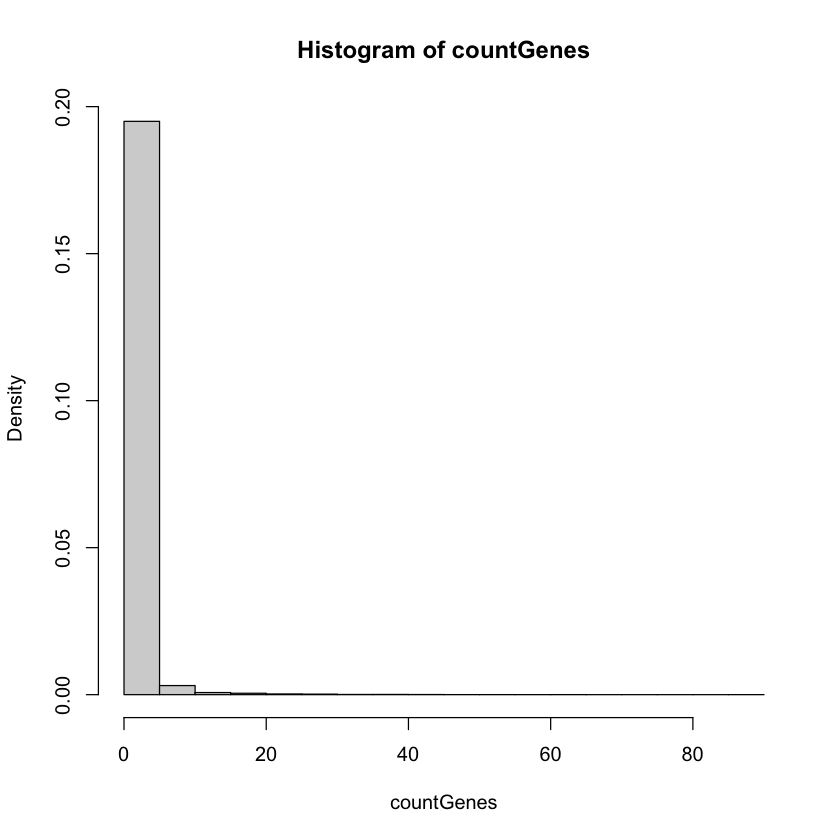

In [21]:
# Note the amount of zeros
sce
countsMatrix = as.matrix(counts(sce))
countGenes = countsMatrix[,"Spermatogonia - 4"]
hist(countGenes, freq=FALSE)


genes = 19974, cells = 18345

<h3> Normalise the data using computeSumFactors and log normalisation </h3>

The computeSumFactors function implements a deconvolution strategy (Lun et al., 2016). It selects a pool of cells with similar library sizes. This avoids inflated estimation errors for very small cells when they are pooled with very large cells. The pooled expression profile is normalized against an average reference pseudo-cell, constructed by averaging the counts across all cells. This defines a size factor for the pool as the median ratio between the count sums and the average across all genes. <br><br>

In [23]:
# Check quality control metrics and normalize the data
qcstats <- perCellQCMetrics(sce)

clusters <- quickCluster(sce)
sce <- computeSumFactors(sce, clusters=clusters)
summary(sizeFactors(sce))

sce <- logNormCounts(sce)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0477  0.4746  0.7879  1.0000  1.3092 13.0231 

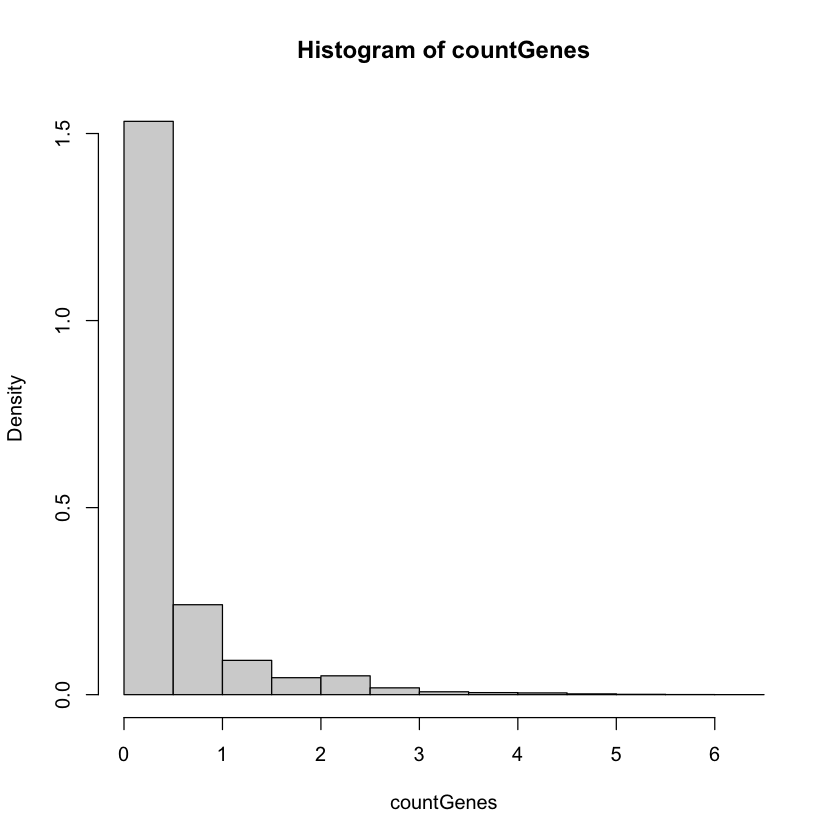

In [26]:
#logcounts(sce)
countsMatrix = as.matrix(logcounts(sce))
countGenes = countsMatrix[,"Spermatogonia - 4"]
hist(countGenes, freq=FALSE)

In [24]:
save(sce, file="data/ernst/spermatogenesisAllCellsErnst.Rdata")

<h3> Filter the data based on transcription factor gene expression </h3>


In [25]:
transcriptionFactors = read.csv(file = "data/transcriptionFactors.csv", header = TRUE )
dim(transcriptionFactors)

sce_TF <- sce[rowData(sce)$Symbol %in% transcriptionFactors$Symbol ,]
sce_TF

[1] 1636    6

class: SingleCellExperiment 
dim: 1505 18345 
metadata(0):
assays(2): counts logcounts
rownames(1505): ENSMUSG00000025902 ENSMUSG00000033740 ...
  ENSMUSG00000006270 ENSMUSG00000043969
rowData names(6): ID Symbol ... ontologyTerm UNIPROT
colnames(18345): S9 - 1 S10 - 2 ... S4 - 53509 S11 - 53510
colData names(15): Sample Barcode ... AnnotatedClusters sizeFactor
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

We have a list  16366 known transcription factors. Our data has 1505 transcription factors after the filter

<h3>Check normalisation </h3>

Check normalisation picking the ENSMUSG00000024837 in the AnnotatedClusters Spermatogonia

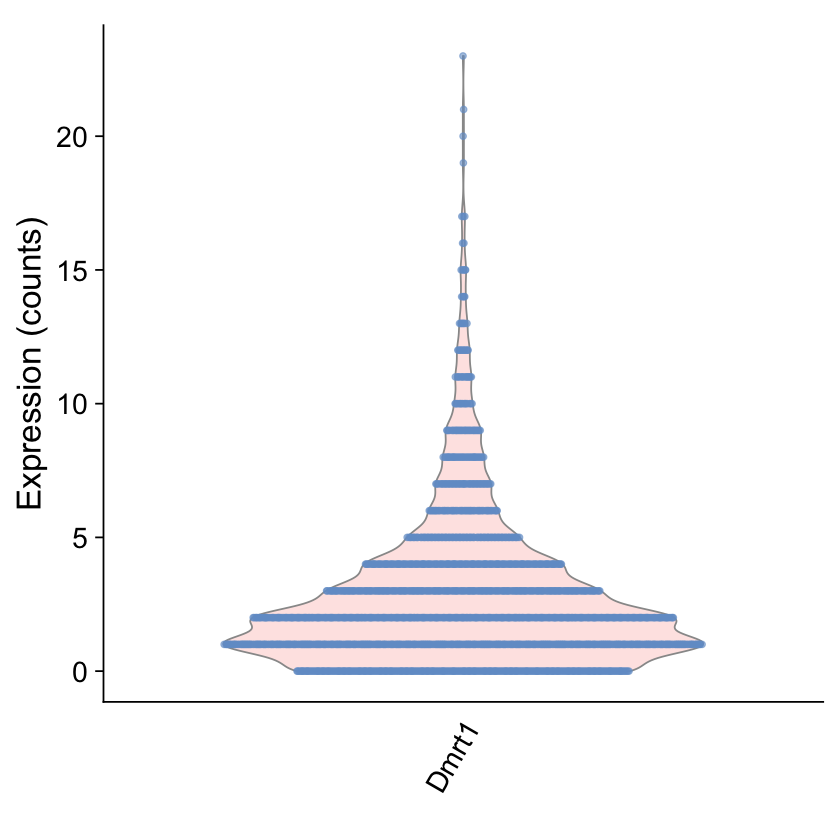

In [85]:
# Before normalisation
testNorm = sce_TF["ENSMUSG00000024837",sce_TF$AnnotatedClusters == "Spermatogonia"]
plotExpression(testNorm, "Dmrt1", exprs_values = "counts", swap_rownames = "Symbol",
               theme_size = 20)

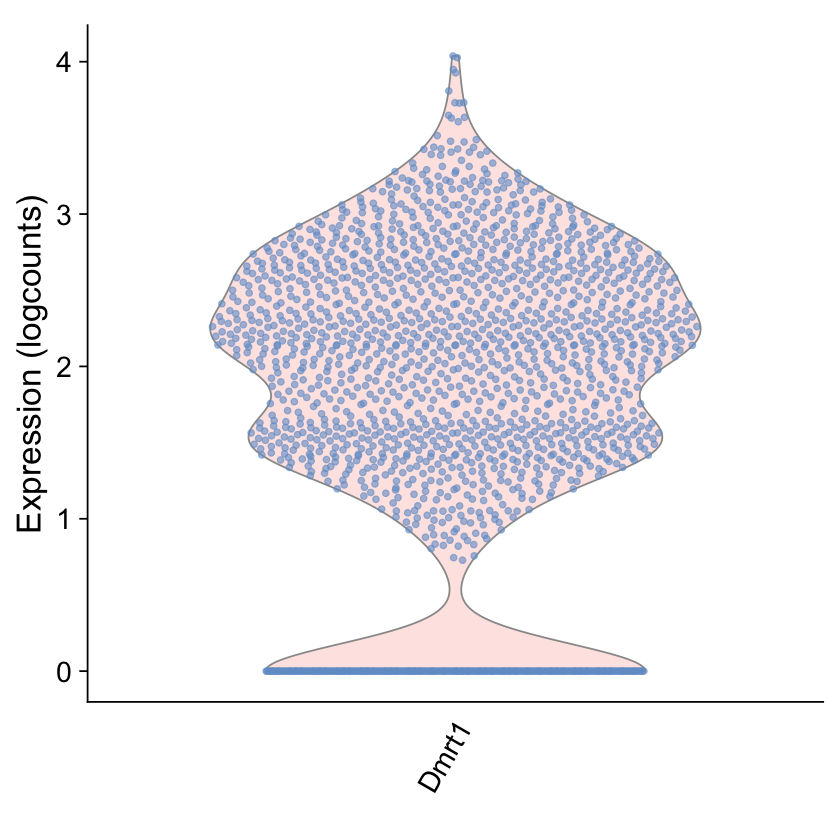

In [88]:
# After normalisation
plotExpression(testNorm, "Dmrt1", exprs_values = "logcounts", swap_rownames = "Symbol",
               theme_size = 20)

In [97]:
plotExpression

ERROR: Error in parse(text = x, srcfile = src): <text>:2:0: unexpected end of input
1: plotExpression?
   ^


In [27]:
save(sce_TF, file="data/ernst/spermatogenesisAllCellsErnstTF.Rdata")

In [89]:
sce_TF

class: SingleCellExperiment 
dim: 1505 18345 
metadata(0):
assays(2): counts logcounts
rownames(1505): ENSMUSG00000025902 ENSMUSG00000033740 ...
  ENSMUSG00000006270 ENSMUSG00000043969
rowData names(6): ID Symbol ... ontologyTerm UNIPROT
colnames(18345): S9 - 1 S10 - 2 ... S4 - 53509 S11 - 53510
colData names(15): Sample Barcode ... AnnotatedClusters sizeFactor
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):